In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.utils import plot_model

2024-04-03 14:46:28.194861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 14:46:28.194955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 14:46:28.358622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
DATA_PATH = "/kaggle/input/fyp-dataset/feralignedck/feraligned+ck/"
TOP_EMOTIONS = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

# Define constants
TRAIN_SIZE = 0.80
INPUT_SHAPE = (75, 75, 3) # input size must 75 x 75
NUM_CLASSES = len(TOP_EMOTIONS)
BATCH_SIZE = 32
EPOCHS = 100

In [ ]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

Surprise has 249 number of images
Fear has 728 number of images
Angry has 938 number of images
Neutral has 1230 number of images
Sadness has 1153 number of images
Happy has 2203 number of images

total images are 6501


In [ ]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f)
            img = cv2.resize(img, (75, 75))

            # Convert image to RGB format if it's grayscale
            if img.shape[-1] == 1:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            img_arr.append(img)
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

img_arr.shape, img_label.shape, label_to_text

loaded Surprise images to numpy arrays...
loaded Fear images to numpy arrays...
loaded Angry images to numpy arrays...
loaded Neutral images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((6501, 75, 75, 3),
 (6501, 6),
 {0: 'Surprise',
  1: 'Fear',
  2: 'Angry',
  3: 'Neutral',
  4: 'Sadness',
  5: 'Happy'})

In [ ]:
# Memory cleanup
del img
del dir_
del f

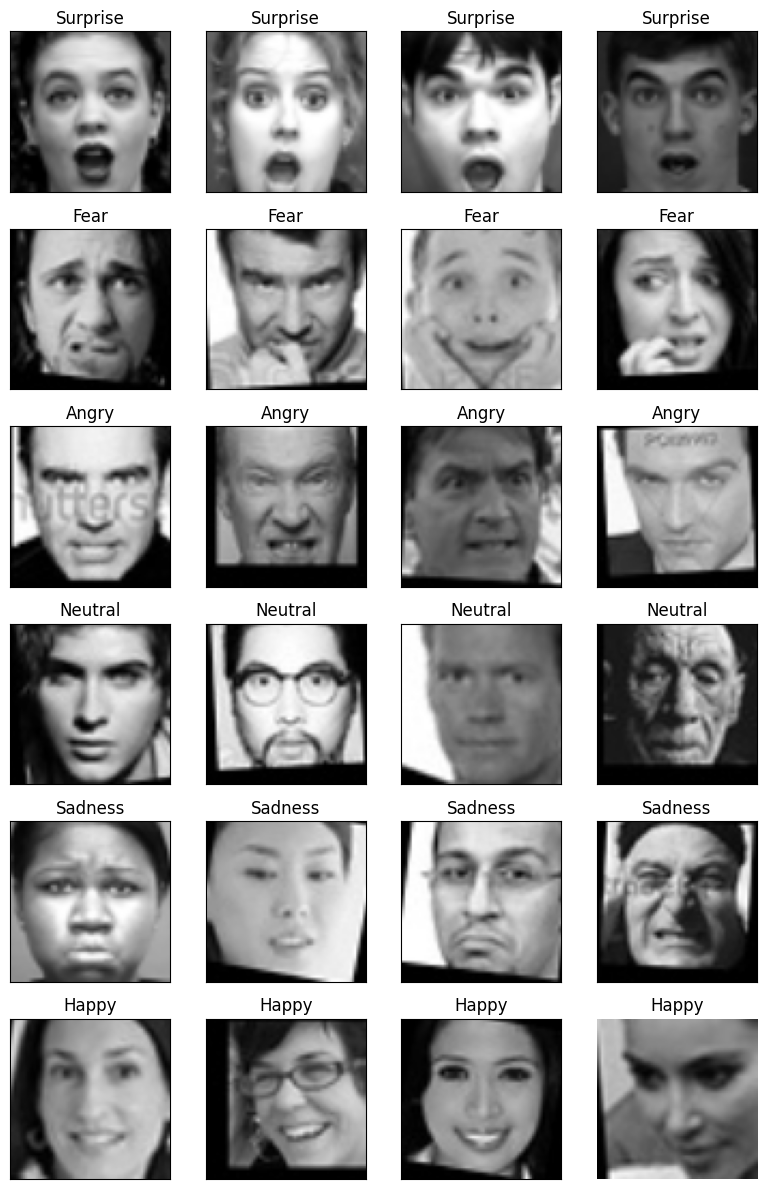

In [ ]:
num_emotions = len(TOP_EMOTIONS)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols * 2, num_emotions * 2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img), plt.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5200, 75, 75, 3), (1301, 75, 75, 3), (5200, 6), (1301, 6))

In [ ]:
# Memory cleanup
del img_arr
del img_label

In [ ]:
# Define a custom callback for early stopping based on validation accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=10, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best = -np.Inf  # Initialize best to negative infinity
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best:
            self.best = current_val_acc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Save the best weights
        elif epoch - self.best_epoch >= self.patience:
            print(f"Epoch {epoch}: Early stopping due to no improvement in {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print(f"Restoring best weights from epoch {self.best_epoch}.")
                self.model.set_weights(self.best_weights)

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

# Fit the data generator on training data
train_datagen.fit(X_train)

In [ ]:
# Load the Xception model
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build custom model architecture on top of pre-trained model
inputs = Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,526 (80.58 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:
custom_early_stopping = CustomEarlyStopping(patience=25)

# Train the top layer
history_top_layer = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=int(len(X_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/162 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.1128 - loss: 2.1595  

I0000 00:00:1712155676.918381      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712155676.948161      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/162 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.3230 - loss: 1.6943

W0000 00:00:1712155684.284118      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3663 - loss: 1.5750

W0000 00:00:1712155692.965372      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


162/162 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.3665 - loss: 1.5743 - val_accuracy: 0.4512 - val_loss: 1.3175 - learning_rate: 0.0010
Epoch 2/100
  1/162 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4375 - loss: 1.3500

W0000 00:00:1712155697.769694      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4375 - loss: 1.3500 - val_accuracy: 0.4620 - val_loss: 1.3117 - learning_rate: 0.0010
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.4620 - loss: 1.3385 - val_accuracy: 0.4873 - val_loss: 1.2931 - learning_rate: 0.0010
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 1.1626 - val_accuracy: 0.4858 - val_loss: 1.2912 - learning_rate: 0.0010
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5092 - loss: 1.2477 - val_accuracy: 0.5242 - val_loss: 1.2332 - learning_rate: 0.0010
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6875 - loss: 1.1904 - val_accuracy: 0.5181 - val_loss: 1.2362 - learning_rate: 0.0010
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5251 - loss: 1.1917 - val_accuracy: 0.5065 - val_loss: 1.2344 - learning_rate: 0.0010
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3125 - loss: 1.5473 - v

In [ ]:
# Create history dataframe for the top layer training
history_top_layer_df = pd.DataFrame(history_top_layer.history)
history_top_layer_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.407895,1.462038,0.451191,1.317479,1.000000e-03
1,0.437500,1.349998,0.461952,1.311658,1.000000e-03
2,0.471943,1.324145,0.487317,1.293092,1.000000e-03
3,0.500000,1.162582,0.485780,1.291218,1.000000e-03
4,0.508707,1.253548,0.524212,1.233239,1.000000e-03
5,0.687500,1.190431,0.518063,1.236215,1.000000e-03
6,0.521672,1.205810,0.506533,1.234431,1.000000e-03
7,0.312500,1.547334,0.510377,1.230742,1.000000e-03
8,0.531540,1.187886,0.521138,1.188897,1.000000e-03
9,0.406250,1.154217,0.517294,1.190141,1.000000e-04


In [ ]:
# Fine-tuning the entire model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model after fine-tuning
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,526 (80.58 MB)

 Trainable params: 21,069,998 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
# Train the entire model end-to-end with a low learning rate
history_fine_tuning = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=int(len(X_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.1719 - loss: 1.7397  

W0000 00:00:1712155976.227111      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 50/162 ━━━━━━━━━━━━━━━━━━━━ 54s 485ms/step - accuracy: 0.2989 - loss: 1.7083

W0000 00:00:1712155999.918743      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.3348 - loss: 1.6459

W0000 00:00:1712156011.299309      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 232ms/step - accuracy: 0.3350 - loss: 1.6455 - val_accuracy: 0.4074 - val_loss: 1.5219 - learning_rate: 1.0000e-05
Epoch 2/100
  1/162 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4688 - loss: 1.5947

W0000 00:00:1712156013.635632      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4688 - loss: 1.5947 - val_accuracy: 0.4074 - val_loss: 1.5215 - learning_rate: 1.0000e-05
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.4293 - loss: 1.4406 - val_accuracy: 0.4051 - val_loss: 1.5104 - learning_rate: 1.0000e-05
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5625 - loss: 1.3074 - val_accuracy: 0.4066 - val_loss: 1.5101 - learning_rate: 1.0000e-05
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.4771 - loss: 1.3414 - val_accuracy: 0.4266 - val_loss: 1.4277 - learning_rate: 1.0000e-05
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5000 - loss: 1.1220 - val_accuracy: 0.4289 - val_loss: 1.4276 - learning_rate: 1.0000e-05
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.5201 - loss: 1.2258 - val_accuracy: 0.4842 - val_loss: 1.2899 - learning_rate: 1.0000e-05
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy:

In [ ]:
# Create history dataframe for fine-tuning
history_fine_tuning_df = pd.DataFrame(history_fine_tuning.history)
history_fine_tuning_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.368421,1.580932,0.407379,1.521855,1.000000e-05
1,0.468750,1.594700,0.407379,1.521460,1.000000e-05
2,0.432856,1.426133,0.405073,1.510416,1.000000e-05
3,0.562500,1.307428,0.406610,1.510058,1.000000e-05
4,0.487616,1.311605,0.426595,1.427662,1.000000e-05
...,...,...,...,...,...
69,0.875000,0.601427,0.666410,0.996296,1.000000e-07
70,0.733359,0.717659,0.671022,1.011657,1.000000e-07
71,0.781250,0.616393,0.671022,1.011378,1.000000e-07
72,0.726780,0.719991,0.668716,0.980588,1.000000e-07


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

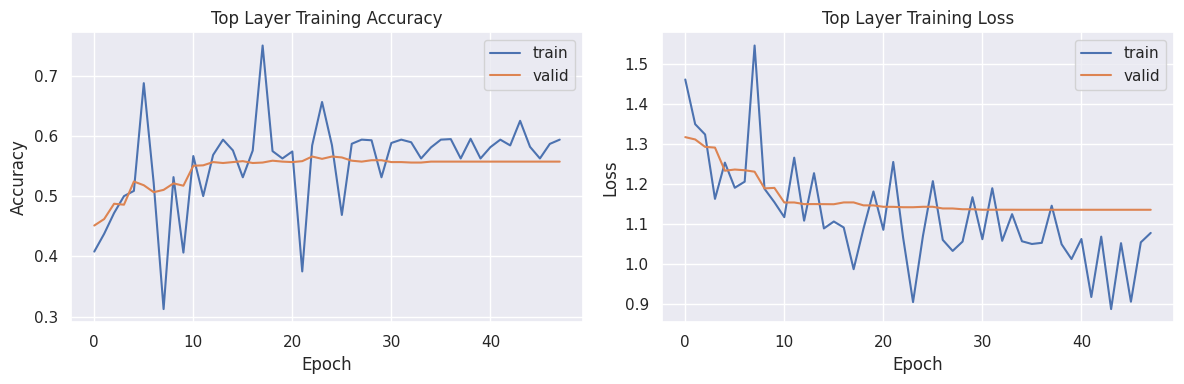

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

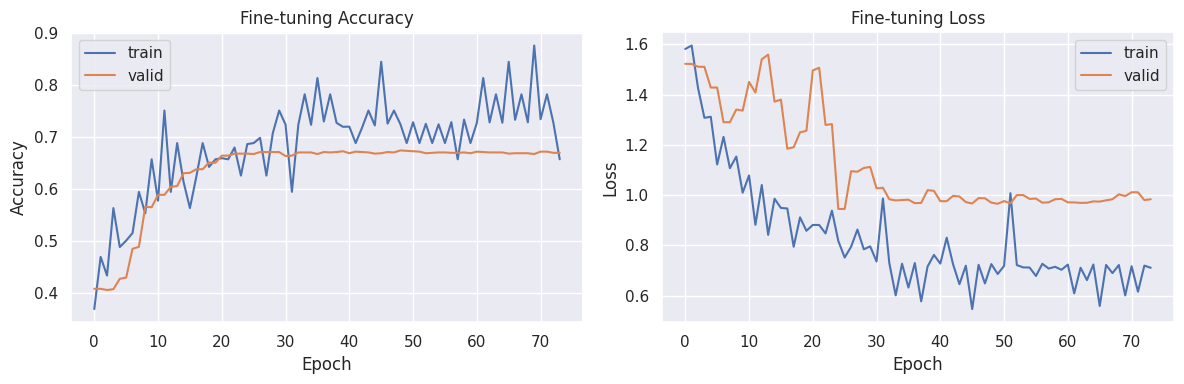

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize training history for the top layer training
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['accuracy'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_accuracy'], label='valid')
plt.title('Top Layer Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['loss'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_loss'], label='valid')
plt.title('Top Layer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

# Visualize training history for fine-tuning
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['accuracy'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_accuracy'], label='valid')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['loss'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_loss'], label='valid')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

163/163 - 5s - 29ms/step - accuracy: 0.7613 - loss: 0.8265


W0000 00:00:1712156513.840116      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



train Accuracy: 0.761346161365509
41/41 - 1s - 21ms/step - accuracy: 0.6733 - loss: 0.9702

Test Accuracy: 0.6733282208442688
 8/41 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

W0000 00:00:1712156518.040829      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


W0000 00:00:1712156521.573968      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Classification Report:
               precision    recall  f1-score   support

       Angry       0.98      1.00      0.99        50
        Fear       0.63      0.48      0.54       145
       Happy       0.68      0.63      0.65       188
     Neutral       0.54      0.66      0.60       246
     Sadness       0.49      0.42      0.45       231
    Surprise       0.81      0.86      0.83       441

    accuracy                           0.67      1301
   macro avg       0.69      0.67      0.68      1301
weighted avg       0.67      0.67      0.67      1301



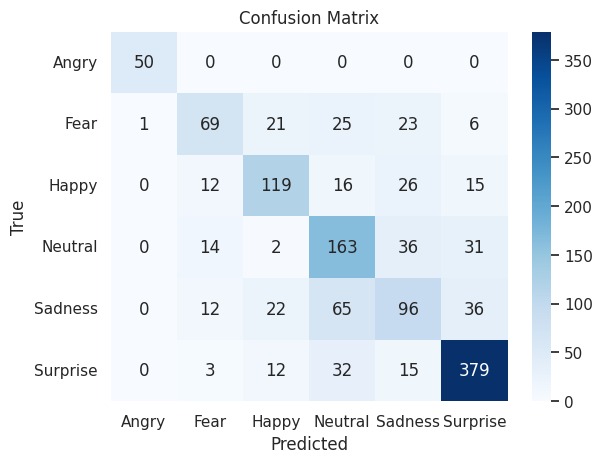

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=TOP_EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TOP_EMOTIONS, yticklabels=TOP_EMOTIONS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
label_to_text

{0: 'Surprise', 1: 'Fear', 2: 'Angry', 3: 'Neutral', 4: 'Sadness', 5: 'Happy'}

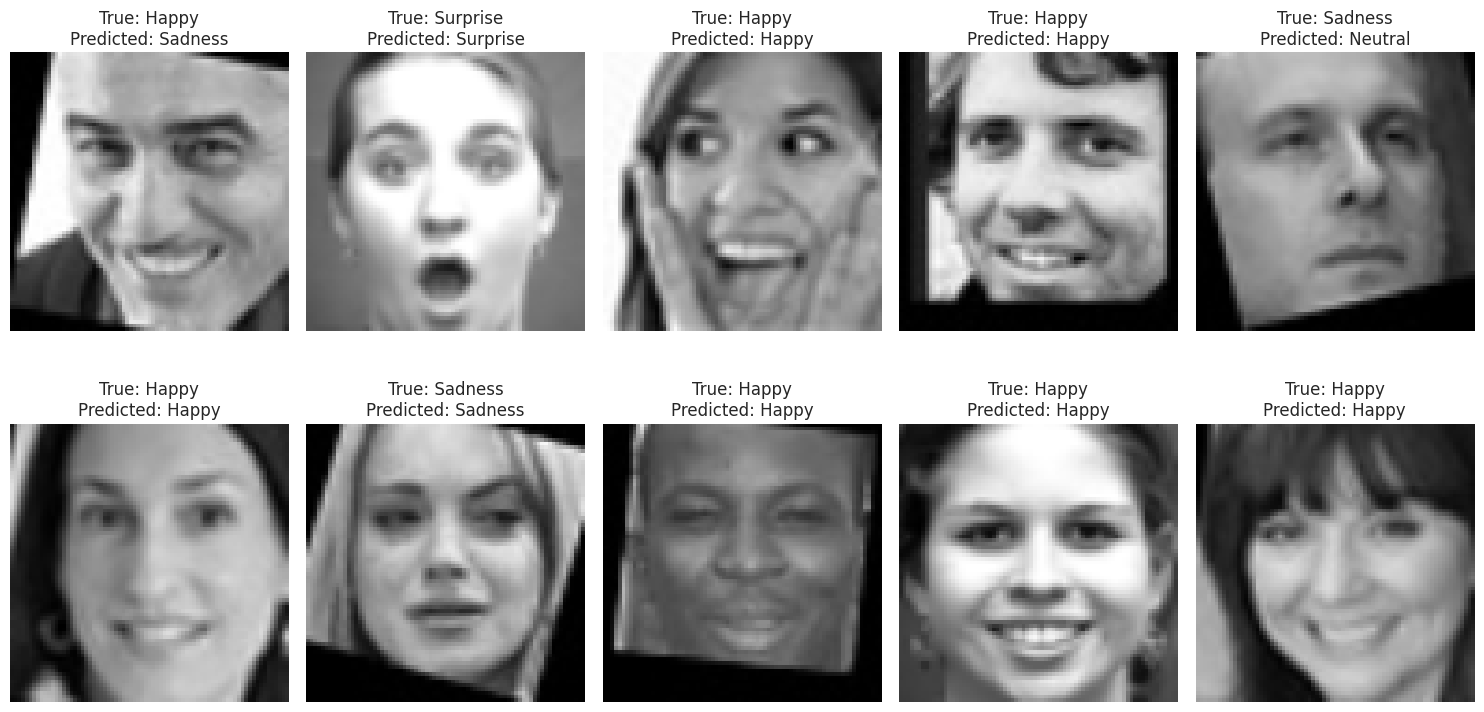

In [ ]:
import random

# Visualize some predictions
num_images_to_visualize = 10
random_indices = np.random.choice(len(X_test), size=num_images_to_visualize, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {label_to_text[true_labels[idx]]}\nPredicted: {label_to_text[predicted_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()